In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import warnings
import scipy
import scipy.stats as scs
%matplotlib inline
warnings.filterwarnings("ignore")

In [9]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from eda_plot import *
from ABtesting import *

In [11]:
# reading the csv file
missing_values = ["n/a", "na", "undefined"]
df = pd.read_csv("../data/AdSmartABdata.csv", na_values=missing_values)
df

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [12]:
respond_df = df.query("not (yes == 0 & no == 0)")
respond_df.shape

(1243, 9)

In [13]:
clean_df = respond_df[['auction_id', 'experiment', 'yes', 'no']]
clean_df['aware'] = 0
clean_df.loc[clean_df['yes'] == 1, 'aware'] = 1
clean_df.loc[clean_df['yes'] == 0, 'aware'] = 0
clean_df.drop(columns=['yes', 'no'], inplace=True)
clean_df = clean_df.set_index('auction_id')
clean_df

,experiment,aware
auction_id,,
0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,0
008aafdf-deef-4482-8fec-d98e3da054da,exposed,1
00a1384a-5118-4d1b-925b-6cdada50318d,exposed,0
00b6fadb-10bd-49e3-a778-290da82f7a8d,control,1
00ebf4a8-060f-4b99-93ac-c62724399483,control,0
...,...,...
ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,1
ffb176df-ecd2-45d3-b05f-05b173a093a7,exposed,1
ffb79718-6f25-4896-b6b3-e58b80a6e147,control,0


##### Summary of the data

In [14]:
summary_df = clean_df.pivot_table( index='experiment', aggfunc='sum')
summary_df['total'] = clean_df.pivot_table( index='experiment', aggfunc='count')
summary_df['rate'] = clean_df.pivot_table( index='experiment')
summary_df['not aware'] = summary_df['total'] - summary_df['aware']
summary_df = summary_df.reindex(['aware', 'not aware', 'total', 'rate'], axis=1)
summary_df

,aware,not aware,total,rate
experiment,,,,
control,264,322,586,0.450512
exposed,308,349,657,0.468798


In [15]:
exp_rate = summary_df['rate']['exposed']
cont_rate = summary_df['rate']['control']

In [16]:
exp_aware = summary_df['aware']['exposed']
cont_aware = summary_df['aware']['control']

In [17]:
exp_total = summary_df['total']['exposed']
cont_total = summary_df['total']['control']

In [18]:
diff = exp_rate - cont_rate

In [19]:
print(f'The difference between conversion rates of the test and control groups is {diff}.')

The difference between conversion rates of the test and control groups is 0.018285619295484168.


#### Binomial Distributions

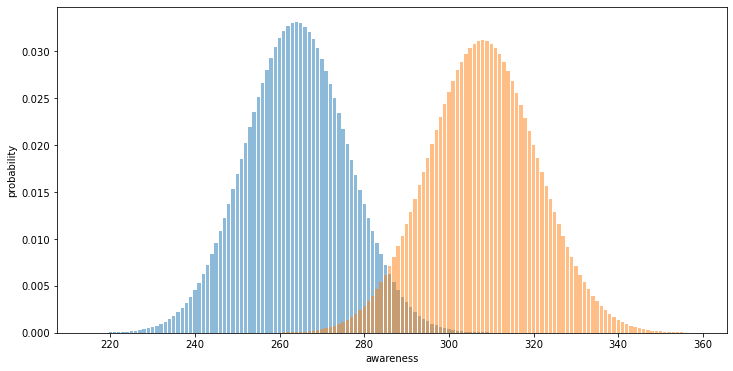

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

xC = np.linspace(cont_aware - 49, cont_aware + 50, 100)
yC = scs.binom(cont_total, cont_rate).pmf(xC)
ax.bar(xC, yC, alpha=0.5, linestyle='--')
xE = np.linspace(exp_aware - 49, exp_aware + 50, 100)
yE = scs.binom(exp_total , exp_rate).pmf(xE)
ax.bar(xE, yE, alpha=0.5, linestyle='--')
plt.xlabel('awareness')
plt.ylabel('probability')
plt.show()

#### Distribution of the sample means

In [21]:
# standard error of the mean
SE_C = np.sqrt(cont_rate * (1-cont_rate)) / np.sqrt(cont_total)
SE_E = np.sqrt(exp_rate * (1-exp_rate)) / np.sqrt(exp_total)

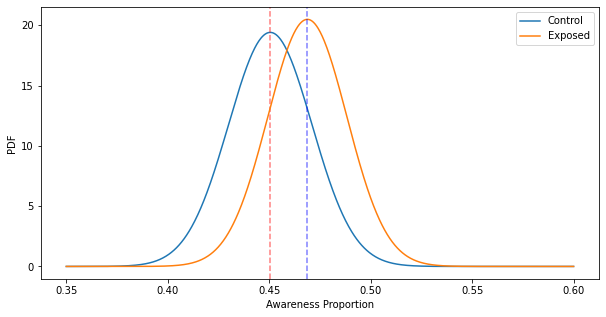

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(cont_rate, SE_C).pdf(x)
ax.plot(x, yC, label='Control')
ax.axvline(x=cont_rate, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(exp_rate, SE_E).pdf(x)
ax.plot(x, yE, label='Exposed')
ax.axvline(x=exp_rate, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Awareness Proportion')
plt.ylabel('PDF')
plt.show()